In [354]:

import xarray as xr
import rioxarray 
from pathlib import Path
import pandas as pd
import numpy as np
import random

In [355]:

def get_bounding_box_max_min_lat_long_values(country_name, df_bounding_boxes):
    # Get min of lat and long for the country
    min_long = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['longmin']
    min_lat = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['latmin']
    # Get max of lat and long for the country
    max_long = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['longmax']
    max_lat = df_bounding_boxes[df_bounding_boxes['country'] == country_name]['latmax']
    return  min_long, min_lat, max_long, max_lat

def get_location_names():
    df_bounding_boxes = pd.read_csv('/Users/kevinha/VYPREarth/UNET_implementation/country-boundingboxes.csv')
    country_names_list = df_bounding_boxes['country'].to_list()
    return country_names_list, df_bounding_boxes

def get_clipped_xarray_dataset(ds, country_name, df_bounding_boxes):
    # CRS code 
    dsc = ds.rio.write_crs(4326) # Need to specify this as Ilektra mentioned 
    
    # Get min of lat and long for the country  and  max of lat and long for the country
    min_long, min_lat, max_long, max_lat = get_bounding_box_max_min_lat_long_values(country_name, df_bounding_boxes)
    
    # Clip the dataset
    ds_clipped = dsc.rio.clip_box(minx= min_long, miny= min_lat, maxx= max_long,maxy= max_lat)
    
    return ds_clipped 


In [356]:
ds=xr.open_zarr('/Users/kevinha/Downloads/seasfirecube.zarr')

/var/folders/fd/c30byq417d3dh1ystdk504100000gp/T/ipykernel_2736/1543556187.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds=xr.open_zarr('/Users/kevinha/Downloads/seasfirecube.zarr')


In [357]:
country_names_list, df_bounding_boxes = get_location_names()
ds_clipped=get_clipped_xarray_dataset(ds,'Nigeria', df_bounding_boxes)

In [358]:
ds_clipped.dims

Frozen({'latitude': 41, 'longitude': 71, 'time': 966})

In [359]:
#image_dataset=ds_clipped.sel(cols=['LST_Day_CMG','NDVI','mslp','ssr','t2mmin','tp','vpd_cf','BurntArea'])

In [360]:
image_dataset = np.array(ds_clipped.to_array())

In [361]:
image_dataset.shape

(35, 966, 41, 71)

In [362]:
print(image_dataset.dtype.names)

None


In [363]:
image_number=random.randint(0,len(image_dataset))

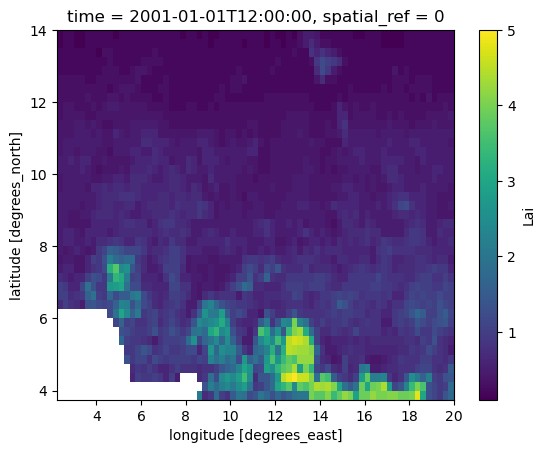

In [364]:
ds_clipped['Lai'].isel(time=0).plot()

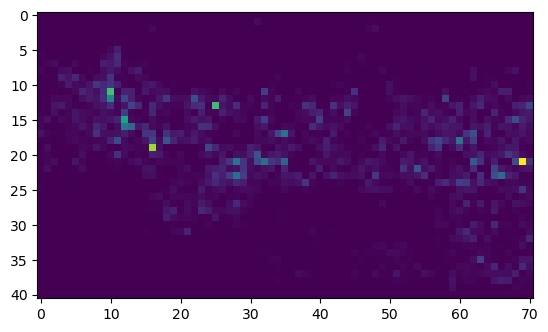

In [365]:

from matplotlib import pyplot as plt
plt.imshow(image_dataset[0][0])

In [366]:
image_dataset=image_dataset[[1,5,7,15,24,27,30,21,32]]

In [367]:
image_dataset.shape

(9, 966, 41, 71)

In [368]:
#burntarea:1 , lst=5, ndvi=7, mslp: 15, ssr: 24, ssv1: 27, t2min:30, tp: 31, vpd_cf:32


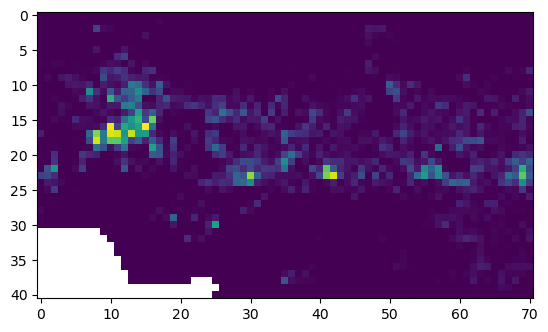

In [369]:
plt.imshow(image_dataset[0][2])

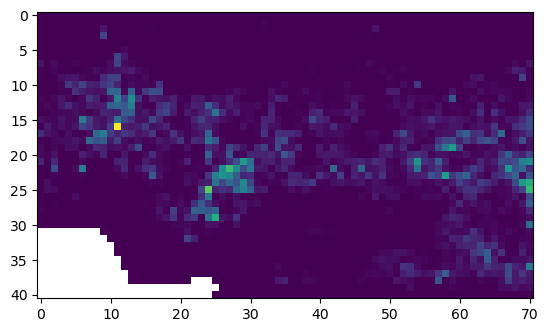

In [370]:

from matplotlib import pyplot as plt
plt.imshow(image_dataset[0][0])

In [371]:
images=[]
masks=[]
for i in range(0, 966):
    if(i%2==0):
        images.append(image_dataset[:,i,:,:])
    else:
        masks.append(image_dataset[:,i,:,:])
                    

In [372]:
for i in range(0,483):
    ba=False
    for j in range(0,41):
        for k in range(0,71):
            if(masks[i][0][j][k]>10000):
                masks[i][0][j][k]=2
            elif(masks[i][0][j][k]>1000):
                masks[i][0][j][k]=1
            else:
                masks[i][0][j][k]=0
   

In [373]:
deletes=[]
for i in range(0,483):
    ba=False
    for j in range(0,41):
        for k in range(0,71):
            if(images[i][0][j][k]>0):
                ba=True
    if ba==False:
        deletes.append(i)

In [374]:
modified_images=[]
modified_masks=[]
for i in range(0,483):
    temp_image=[]
    temp_mask=[]
    for x in range(0,32):
        temp_image_row=[]
        temp_mask_row=[]
        for y in range(38,70):
            temp_image_pixel=[]
            temp_mask_pixel=[]
            for j in range(0,8):
                temp_image_pixel_feature=images[i][j][x][y]
                temp_image_pixel.append(temp_image_pixel_feature)
                
            temp_mask_pixel_feature=masks[i][0][x][y]
            temp_mask_pixel.append(temp_mask_pixel_feature)
                
            temp_image_row.append(temp_image_pixel)
            temp_mask_row.append(temp_mask_pixel)
            
        temp_image.append(temp_image_row)
        temp_mask.append(temp_mask_row)
        
    modified_images.append(temp_image)
    modified_masks.append(temp_mask)
                
    

In [375]:
images=np.asarray(modified_images)
masks=np.asarray(modified_masks)

In [376]:

images=np.delete(images, deletes, 0)


In [377]:
images.shape

(330, 32, 32, 8)

In [378]:
masks=np.delete(masks, deletes,0)
masks.shape

(330, 32, 32, 1)

In [379]:
modified_masks_cat=[]
for i in range(0,330):
    one_time=[]
    for j in range(0,32):
        one_row=[]
        for k in range(0,32):
            if(masks[i][j][k][0]==0):
                one_row.append([1.0,0.0,0.0])
            elif(masks[i][j][k][0]==1):
                one_row.append([0.0,1.0,0.0])
            else:
                one_row.append([0.0,0.0,1.0])
        one_time.append(one_row)
    modified_masks_cat.append(one_time)


In [380]:
masks=np.asarray(modified_masks_cat)
masks.shape

(330, 32, 32, 3)

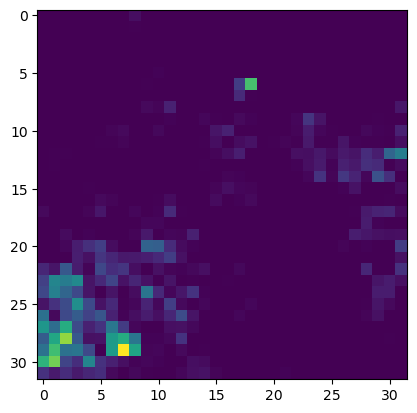

In [381]:
plt.imshow(images[16,:,:,0])

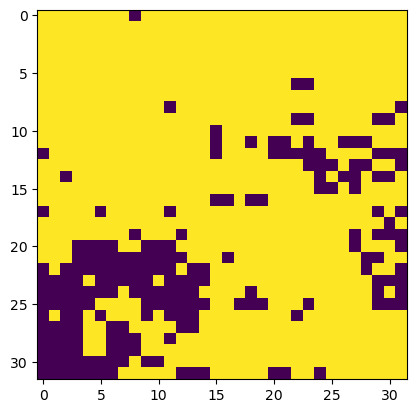

In [382]:
plt.imshow(masks[16,:,:,0])

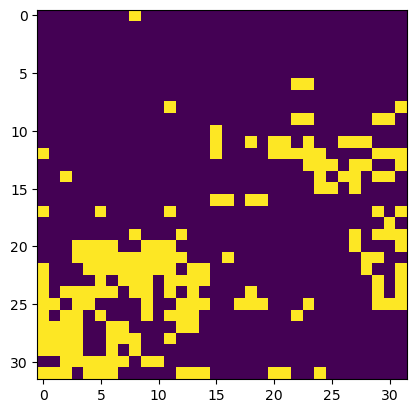

In [383]:
plt.imshow(masks[16,:,:,1])

In [384]:
from scipy import stats

for i in range(0,330):
    for j in range(0,8):
        images[np.isnan(images)] = 0
        images[i,:,:,j]=stats.zscore(images[i,:,:,j])
        

In [385]:
images.dtype

dtype('float32')

In [386]:
masks.dtype

dtype('float64')

In [387]:
images = images.astype(float)

In [388]:
images.dtype

dtype('float64')

In [389]:
masks=masks.astype(float)

In [390]:
masks.shape

(330, 32, 32, 3)

In [391]:
#!pip install tensorflow

#!pip install keras
#!pip install -U --pre segmentation-models

In [392]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [393]:
def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs=Input((IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS))
    s=inputs
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    #c9 = Dropout(0.2)(c9)  # Original 0.1
    #c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
    

In [394]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(images, masks, test_size=0.20, random_state=42)

In [395]:
y_train.shape

(264, 32, 32, 3)

In [396]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
 
#IMG_HEIGHT = 32
#IMG_WIDTH  = 32
#IMG_CHANNELS = 9

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=3, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 8)]  0           []                               
                                                                                                  
 conv2d_381 (Conv2D)            (None, 32, 32, 16)   1168        ['input_22[0][0]']               
                                                                                                  
 dropout_171 (Dropout)          (None, 32, 32, 16)   0           ['conv2d_381[0][0]']             
                                                                                                  
 conv2d_382 (Conv2D)            (None, 32, 32, 16)   2320        ['dropout_171[0][0]']            
                                                                                           

In [398]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 5, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
53/53 [==============================] - 2s 46ms/step - loss: 0.1167 - accuracy: 0.9558 - jacard_coef: 0.8794 - val_loss: 0.1156 - val_accuracy: 0.9577 - val_jacard_coef: 0.8715
Epoch 2/100
31/53 [================>.............] - ETA: 0s - loss: 0.1115 - accuracy: 0.9578 - jacard_coef: 0.8834

KeyboardInterrupt: 

In [399]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [400]:
y_pred=model.predict(X_test)
np.unique(y_pred, return_counts=True)

3/3 [==============================] - 0s 15ms/step


(array([7.3202964e-36, 1.3062390e-35, 1.4005456e-35, ..., 9.9999970e-01,
        9.9999982e-01, 9.9999994e-01], dtype=float32),
 array([    1,     1,     1, ...,   839,  1712, 10506]))

1/1 [==============================] - 0s 25ms/step


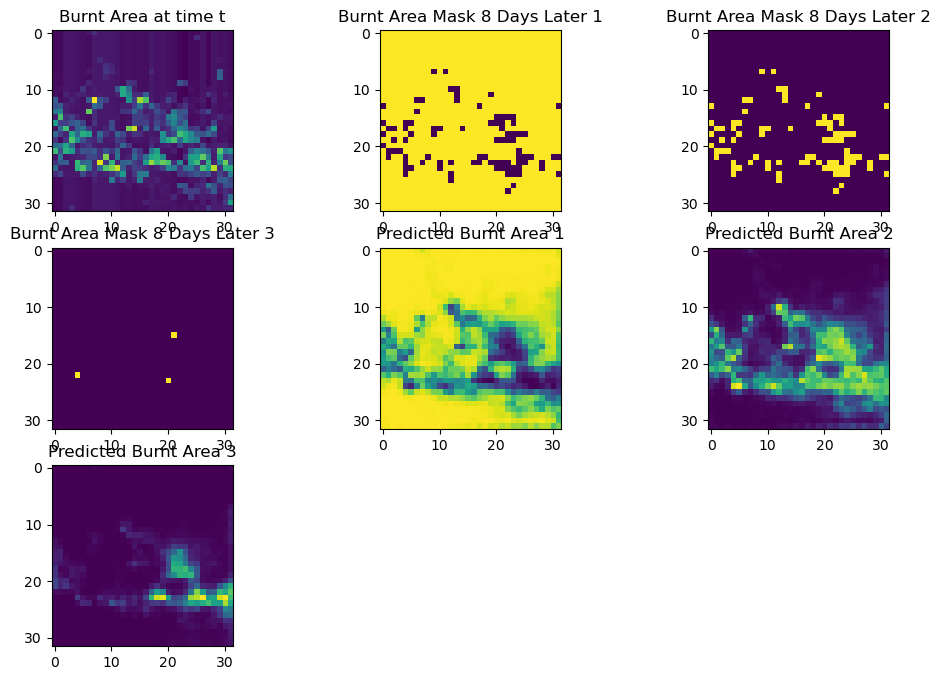

In [426]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
np.unique(prediction, return_counts=True)
predicted_img=prediction[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(331)
plt.title('Burnt Area at time t')
plt.imshow(test_img[:,:,0])
plt.subplot(332)
plt.title('Burnt Area Mask 8 Days Later 1')
plt.imshow(ground_truth[:,:,0])
plt.subplot(333)
plt.title('Burnt Area Mask 8 Days Later 2')
plt.imshow(ground_truth[:,:,1])
plt.subplot(334)
plt.title('Burnt Area Mask 8 Days Later 3')
plt.imshow(ground_truth[:,:,2])
plt.subplot(335)
plt.title('Predicted Burnt Area 1')
plt.imshow(predicted_img[:,:,0])
plt.subplot(336)
plt.title('Predicted Burnt Area 2')
plt.imshow(predicted_img[:,:,1])
plt.subplot(337)
plt.title('Predicted Burnt Area 3')
plt.imshow(predicted_img[:,:,2])
plt.show()

